In [1]:
# Import libraries
import sys

import networkx as nx
import pandas as pd
import numpy as np
import os

import stellargraph as sg
from stellargraph import StellarGraph
from stellargraph.mapper import GraphSAGENodeGenerator, FullBatchNodeGenerator
from stellargraph.layer import GraphSAGE, GCN

import tensorflow as tf
from tensorflow import keras
from keras import layers, optimizers, losses, metrics, Model
from sklearn import preprocessing, feature_extraction, model_selection

import json

In [ ]:
# Setup GPU

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

## Load Data and Preprocessing

In [2]:
# Import dataset
G = nx.read_graphml( "data/cora/cora.graphml" )

print(G) # should print a graph with 2708 nodes and 5429 edges (directed) 

# in this case, we have created a undirected graph, so the numbers of edges are diffent from the original paper

Graph with 2708 nodes and 5278 edges


In [ ]:
G.graph

In [ ]:
print( json.dumps( list( G.nodes(data=True) )[0], indent = 4 ) ) # 1-1432: weights, 1433: subject

In [ ]:
for node in G.nodes():
    print( G.nodes[node]['subject'] )
    break

In [3]:
# for each node, encode weight as a feature
for node in G.nodes():
    enc = [ val for key, val in G.nodes[node].items() if key != 'subject' and key != 'label' ]
    G.nodes[node]['feature'] = enc

In [ ]:
for node in G.nodes( data=True ):
    print( node )
    break

In [4]:
# copy graph
from copy import deepcopy
G2 = deepcopy(G)

# remove redundant weight attributes from nodes
for node in G2.nodes():
    for key in G2.nodes[node].keys():
        if key != 'subject' and key != 'label' and key != 'feature':
            G.nodes[node].pop(key)

del G2

In [ ]:
# print node attributes
for node in G.nodes( data=True ):
    print( node )
    break

In [ ]:
print( json.dumps( list( G.nodes(data=True) )[0], indent = 4 ) )

In [ ]:
print( json.dumps( list( G.edges(data=True) )[0], indent = 4 ) )

## Create StellarGraph

In [5]:
SG = StellarGraph.from_networkx(
    graph=G, node_type_default="subject", node_features="feature"
)

print( SG.info() )

StellarGraph: Undirected multigraph
 Nodes: 2708, Edges: 5278

 Node types:
  paper: [2708]
    Features: float32 vector, length 1433
    Edge types: paper-cites->paper

 Edge types:
    paper-cites->paper: [5278]
        Weights: all 1 (default)
        Features: none


In [7]:
# create a node_subjects Pandas Series with node IDs as index and subject as value
node_subjects = pd.Series( [ G.nodes[node]['subject'] for node in G.nodes() ], index = G.nodes() )
print( node_subjects.head() )

1033       Genetic_Algorithms
35         Genetic_Algorithms
103482        Neural_Networks
103515     Genetic_Algorithms
1050679    Genetic_Algorithms
dtype: object


In [8]:
# split into train and test sets
train_subjects, test_subjects = model_selection.train_test_split(
    node_subjects, train_size=0.7, test_size=None, stratify=node_subjects
)

test_subjects, val_subjects = model_selection.train_test_split(
    test_subjects, train_size=0.5, test_size=None, stratify=test_subjects
)

print( train_subjects )

33412            Neural_Networks
1107067               Case_Based
1106630          Neural_Networks
470511                Case_Based
1123530       Genetic_Algorithms
                   ...          
171225           Neural_Networks
640617        Genetic_Algorithms
735311           Neural_Networks
239810                Case_Based
108962     Probabilistic_Methods
Length: 1895, dtype: object


In [ ]:
from collections import Counter
Counter(train_subjects) # consider imbalance between class

In [9]:
# One-Hot encoding
le = preprocessing.LabelBinarizer()
train_targets = le.fit_transform(train_subjects)
test_targets = le.transform(test_subjects)
val_targets = le.transform(val_subjects)

In [ ]:
print( train_targets ) # for each node, the subject is encoded as a number

# check its shape, should be (270, 7)
print( train_targets.shape )

## Define benchmarking metrics

In [9]:
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, roc_auc_score, accuracy_score, classification_report

# write a function to calculate benchmark metrics

def calculate_metrics(y_true, y_pred):

    precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='micro')
    accuracy = accuracy_score(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred)
    cr = classification_report(y_true, y_pred)

    return precision, recall, f1, accuracy, cm, cr

## GraphSAGE model

In [10]:
batch_size = 50
num_samples = [10, 10]

generator = GraphSAGENodeGenerator( SG, batch_size, num_samples )

In [11]:
train_gen = generator.flow( train_subjects.index, train_targets, shuffle = True )

In [12]:
graphsage_model = GraphSAGE(
    layer_sizes=[32, 32], generator=generator, bias=True, dropout=0.5, activations=["relu", "relu"]
)

In [13]:
print( train_targets.shape )

(1895, 7)


In [14]:
x_inp, x_out = graphsage_model.in_out_tensors()
prediction = layers.Dense(units=train_targets.shape[1], activation="softmax")(x_out)

### Train model

In [15]:
model = Model(inputs=x_inp, outputs=prediction)
model.compile(
    optimizer=optimizers.Adam( learning_rate=0.005 ),
    loss=losses.categorical_crossentropy,
    metrics=["acc"],
)

In [17]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 10, 1433)]   0           []                               
                                                                                                  
 input_3 (InputLayer)           [(None, 100, 1433)]  0           []                               
                                                                                                  
 input_1 (InputLayer)           [(None, 1, 1433)]    0           []                               
                                                                                                  
 reshape (Reshape)              (None, 1, 10, 1433)  0           ['input_2[0][0]']                
                                                                                              

In [16]:
val_gen = generator.flow( val_subjects.index, val_targets)

In [42]:
history = model.fit(
    train_gen, epochs=20, validation_data= val_gen, verbose=2, shuffle=False
)

Epoch 1/20
38/38 - 7s - loss: 1.6169 - acc: 0.4749 - val_loss: 1.2664 - val_acc: 0.7685 - 7s/epoch - 196ms/step
Epoch 2/20
38/38 - 7s - loss: 1.1282 - acc: 0.7984 - val_loss: 0.9543 - val_acc: 0.8473 - 7s/epoch - 187ms/step
Epoch 3/20
38/38 - 7s - loss: 0.8348 - acc: 0.8770 - val_loss: 0.7546 - val_acc: 0.8547 - 7s/epoch - 182ms/step
Epoch 4/20
38/38 - 6s - loss: 0.6426 - acc: 0.8923 - val_loss: 0.6351 - val_acc: 0.8448 - 6s/epoch - 164ms/step
Epoch 5/20
38/38 - 5s - loss: 0.5088 - acc: 0.9124 - val_loss: 0.5845 - val_acc: 0.8448 - 5s/epoch - 139ms/step
Epoch 6/20
38/38 - 6s - loss: 0.4355 - acc: 0.9161 - val_loss: 0.5235 - val_acc: 0.8645 - 6s/epoch - 148ms/step
Epoch 7/20
38/38 - 6s - loss: 0.3647 - acc: 0.9303 - val_loss: 0.5437 - val_acc: 0.8522 - 6s/epoch - 166ms/step
Epoch 8/20
38/38 - 5s - loss: 0.3223 - acc: 0.9245 - val_loss: 0.5411 - val_acc: 0.8547 - 5s/epoch - 132ms/step
Epoch 9/20
38/38 - 5s - loss: 0.2883 - acc: 0.9351 - val_loss: 0.5001 - val_acc: 0.8670 - 5s/epoch - 127

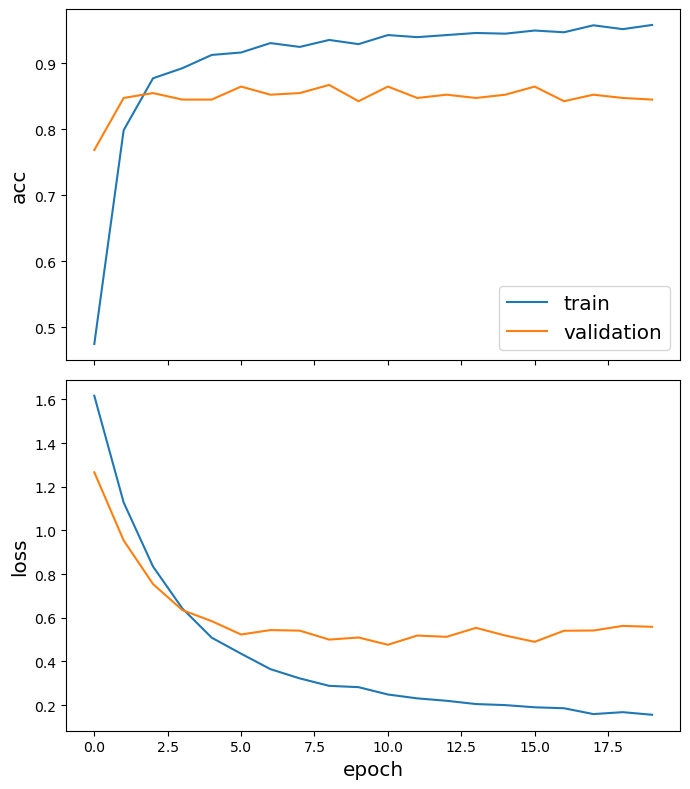

In [43]:
sg.utils.plot_history(history)

In [44]:
test_gen = generator.flow( test_subjects.index, test_targets )

In [45]:
test_metrics = model.evaluate(test_gen)
print("\nTest Set Metrics:")
for name, val in zip(model.metrics_names, test_metrics):
    print("\t{}: {:0.4f}".format(name, val))

9/9 [==============================] - 1s 107ms/step - loss: 0.4138 - acc: 0.8894

Test Set Metrics:
	loss: 0.4138
	acc: 0.8894


### Benchmark model

In [46]:
all_nodes = node_subjects.index
all_mapper = generator.flow(all_nodes)
all_predictions = model.predict(all_mapper)

55/55 [==============================] - 6s 102ms/step


In [47]:
node_predictions = le.inverse_transform(all_predictions)

In [48]:
df = pd.DataFrame({"Predicted": node_predictions, "True": node_subjects})
df.head(10)

,Predicted,True
1033,Genetic_Algorithms,Genetic_Algorithms
35,Genetic_Algorithms,Genetic_Algorithms
103482,Genetic_Algorithms,Neural_Networks
103515,Genetic_Algorithms,Genetic_Algorithms
1050679,Genetic_Algorithms,Genetic_Algorithms
1103960,Genetic_Algorithms,Genetic_Algorithms
1103985,Genetic_Algorithms,Genetic_Algorithms
1109199,Genetic_Algorithms,Genetic_Algorithms
1112911,Genetic_Algorithms,Genetic_Algorithms
1113438,Genetic_Algorithms,Genetic_Algorithms


In [49]:
df['Correct'] = df['Predicted'] == df['True']
df['Correct'].value_counts()

True     2562
False     146
Name: Correct, dtype: int64

In [50]:
# compute confusion matrix
confusion_matrix(df['True'], df['Predicted'])

array([[283,   2,   2,   3,   0,   4,   4],
       [  1, 414,   1,   1,   0,   1,   0],
       [  3,   7, 783,   8,   8,   1,   8],
       [  2,   0,  14, 398,   1,   2,   9],
       [  2,   4,   2,   1, 205,   0,   3],
       [  3,   0,   2,   1,   1, 168,   5],
       [  5,   1,  11,  11,   3,   9, 311]], dtype=int64)

In [ ]:
accuracy = df['Correct'].value_counts()[True] / df['Correct'].value_counts().sum()
print( accuracy )

In [51]:
# calculate precision, recall, f1-score
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, roc_auc_score
precision, recall, f1, _ = precision_recall_fscore_support(df['True'], df['Predicted'], average='micro')
print( precision, recall, f1 )

0.9460856720827179 0.9460856720827179 0.9460856720827179


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score

y_true = df['True']
y_pred = df['Predicted']

# Print the confusion matrix
cm = confusion_matrix(y_true, y_pred)
print("Confusion matrix:\n%s" % cm)

# Print the classification report
cr = classification_report(y_true, y_pred)
print("\nClassification report:\n%s" % cr)

In [ ]:
# calculate metrics

precision, recall, f1, accuracy, cm, cr = calculate_metrics(y_true, y_pred)

In [ ]:
# print metrics

print( "Precision: ", precision )
print( "Recall: ", recall )
print( "F1: ", f1 )
print( "Accuracy: ", accuracy )
print( "Confusion matrix:\n%s" % cm )
print( "Classification report:\n%s" % cr )

In [ ]:
# compute ROC AUC score



## GCN model

In [12]:
train_subjects, test_subjects = model_selection.train_test_split(
    node_subjects, train_size=0.7, test_size=None, stratify=node_subjects
)

val_subjects, test_subjects = model_selection.train_test_split(
    test_subjects, train_size=0.5, test_size=None, stratify=test_subjects
)

In [13]:
train_subjects.value_counts().to_frame() # why is equal to demo?

,0
Neural_Networks,572
Probabilistic_Methods,298
Genetic_Algorithms,292
Theory,246
Case_Based,209
Reinforcement_Learning,152
Rule_Learning,126


In [14]:
# Convert to numeric labels
le = preprocessing.LabelBinarizer()
train_targets = le.fit_transform(train_subjects)
val_targets = le.transform(val_subjects)
test_targets = le.transform(test_subjects)

In [15]:
generator = FullBatchNodeGenerator(SG, method="gcn")

Using GCN (local pooling) filters...


In [16]:
train_gen = generator.flow(train_subjects.index, train_targets)

In [17]:
gcn = GCN(
    layer_sizes=[32, 32], activations=["relu", "relu"], generator=generator, dropout=0.5
)

In [18]:
x_inp, x_out = gcn.in_out_tensors()
predictions = layers.Dense(units=train_targets.shape[1], activation="softmax")(x_out)

In [20]:
model = Model(inputs=x_inp, outputs=predictions)
model.compile(
    optimizer=optimizers.Adam( learning_rate=0.005 ),
    loss=losses.categorical_crossentropy,
    metrics=["acc"],
)

In [60]:
# model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(1, 2708, 1433)]    0           []                               
                                                                                                  
 input_3 (InputLayer)           [(1, None, 2)]       0           []                               
                                                                                                  
 input_4 (InputLayer)           [(1, None)]          0           []                               
                                                                                                  
 dropout (Dropout)              (1, 2708, 1433)      0           ['input_1[0][0]']                
                                                                                              

In [21]:
val_gen = generator.flow(val_subjects.index, val_targets)

In [17]:
from tensorflow.keras.callbacks import EarlyStopping

es_callback = EarlyStopping(monitor="val_acc", patience=50, restore_best_weights=True)

In [22]:
history = model.fit(
    train_gen,
    epochs=200,
    validation_data=val_gen,
    verbose=2,
    shuffle=False,  # this should be False, since shuffling data means shuffling the whole graph
    # callbacks=[es_callback],
)

Epoch 1/200
1/1 - 2s - loss: 1.9623 - acc: 0.1150 - val_loss: 1.9214 - val_acc: 0.3596 - 2s/epoch - 2s/step
Epoch 2/200
1/1 - 0s - loss: 1.9223 - acc: 0.2670 - val_loss: 1.8920 - val_acc: 0.3842 - 181ms/epoch - 181ms/step
Epoch 3/200
1/1 - 0s - loss: 1.8913 - acc: 0.3625 - val_loss: 1.8555 - val_acc: 0.3768 - 183ms/epoch - 183ms/step
Epoch 4/200
1/1 - 0s - loss: 1.8546 - acc: 0.3815 - val_loss: 1.8107 - val_acc: 0.3695 - 370ms/epoch - 370ms/step
Epoch 5/200
1/1 - 0s - loss: 1.8102 - acc: 0.4016 - val_loss: 1.7568 - val_acc: 0.3941 - 146ms/epoch - 146ms/step
Epoch 6/200
1/1 - 0s - loss: 1.7548 - acc: 0.4011 - val_loss: 1.6915 - val_acc: 0.4286 - 163ms/epoch - 163ms/step
Epoch 7/200
1/1 - 0s - loss: 1.6993 - acc: 0.4290 - val_loss: 1.6151 - val_acc: 0.4729 - 154ms/epoch - 154ms/step
Epoch 8/200
1/1 - 0s - loss: 1.6294 - acc: 0.4290 - val_loss: 1.5307 - val_acc: 0.5222 - 147ms/epoch - 147ms/step
Epoch 9/200
1/1 - 0s - loss: 1.5551 - acc: 0.4887 - val_loss: 1.4447 - val_acc: 0.5468 - 181ms

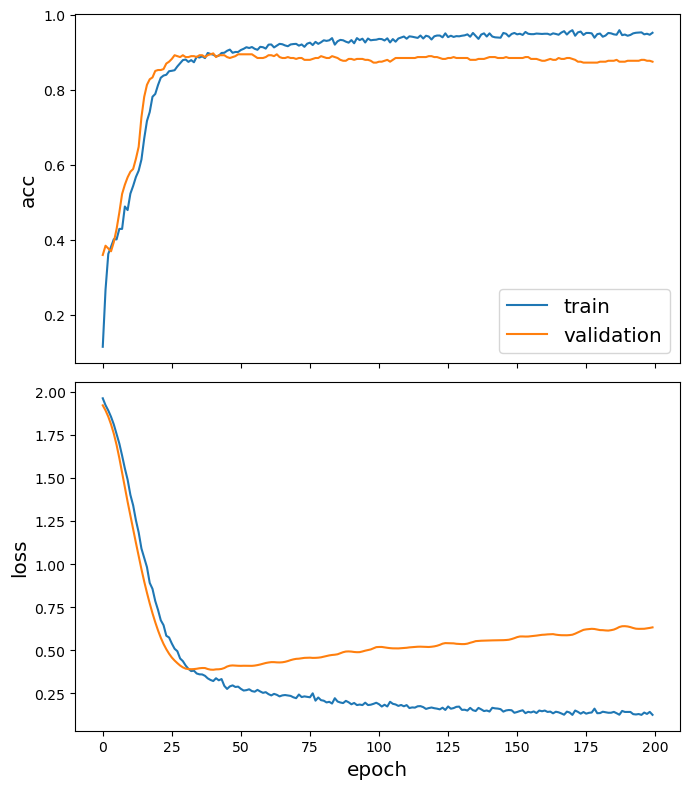

In [23]:
sg.utils.plot_history(history)

In [24]:
test_gen = generator.flow(test_subjects.index, test_targets)

In [25]:
test_metrics = model.evaluate(test_gen)
print("\nTest Set Metrics:")
for name, val in zip(model.metrics_names, test_metrics):
    print("\t{}: {:0.4f}".format(name, val))

1/1 [==============================] - 0s 82ms/step - loss: 0.4926 - acc: 0.8747

Test Set Metrics:
	loss: 0.4926
	acc: 0.8747


### Benchmark

In [26]:
all_nodes = node_subjects.index
all_mapper = generator.flow(all_nodes)
all_predictions = model.predict(all_mapper)

1/1 [==============================] - 0s 230ms/step


In [27]:
# Inverse transform the predictions to get the node labels
node_predictions = le.inverse_transform(all_predictions.squeeze())

In [28]:
df = pd.DataFrame({"Predicted": node_predictions, "True": node_subjects})
df.head(20)

,Predicted,True
1033,Genetic_Algorithms,Genetic_Algorithms
35,Genetic_Algorithms,Genetic_Algorithms
103482,Theory,Neural_Networks
103515,Genetic_Algorithms,Genetic_Algorithms
1050679,Genetic_Algorithms,Genetic_Algorithms
1103960,Genetic_Algorithms,Genetic_Algorithms
1103985,Genetic_Algorithms,Genetic_Algorithms
1109199,Genetic_Algorithms,Genetic_Algorithms
1112911,Genetic_Algorithms,Genetic_Algorithms
1113438,Genetic_Algorithms,Genetic_Algorithms


In [29]:
df['Correct'] = df['Predicted'] == df['True']
df['Correct'].value_counts()

True     2575
False     133
Name: Correct, dtype: int64

In [30]:
print( le.classes_ )

['Case_Based' 'Genetic_Algorithms' 'Neural_Networks'
 'Probabilistic_Methods' 'Reinforcement_Learning' 'Rule_Learning' 'Theory']


In [46]:
y_true = df['True']
y_pred = df['Predicted']

# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=le.classes_)
print("Confusion matrix:\n%s\n" % cm)

# for each class, calculate tp, fp, fn, tn and save to a dictionary
# tp = true positive, fp = false positive, fn = false negative, tn = true negative

cm_dict = {}
for i, label in enumerate(le.classes_):
    tp = cm[i, i]
    fp = cm[:, i].sum() - tp
    fn = cm[i, :].sum() - tp
    tn = cm.sum() - tp - fp - fn

    cm_dict[label] = {"tp": tp, "fp": fp, "fn": fn, "tn": tn}

# print the confusion matrix dictionary
print( cm_dict )

# sum all tp, fp, fn, tn
tp = fp = fn = tn = 0
for label in le.classes_ :
    tp += cm_dict[label]['tp']
    fp += cm_dict[label]['fp']
    fn += cm_dict[label]['fn']
    tn += cm_dict[label]['tn']

# print the sum of tp, fp, fn, tn
print( tp, fp, fn, tn )

# calculate precision, recall, f1-score
# precision = tp / (tp + fp)
# recall = tp / (tp + fn)
# f1 = 2 * (precision * recall) / (precision + recall)

precision = tp / (tp + fp)
recall = tp / (tp + fn)
f1 = 2 * (precision * recall) / (precision + recall)

# print the metrics
print( precision, recall, f1 ) # so it is the same as compute_metrics function returns

# -> Quindi anche la funzione compute_metrics è sbagliata, perché non calcola bene la precision, recall e f1


Confusion matrix:
[[284   1   3   2   2   2   4]
 [  5 411   0   0   2   0   0]
 [  8   4 776  11   5   1  13]
 [  0   0   7 410   0   0   9]
 [  1   3   7   1 201   0   4]
 [  5   0   0   2   0 168   5]
 [  4   1   6  10   3   2 325]]

{'Case_Based': {'tp': 284, 'fp': 23, 'fn': 14, 'tn': 2387}, 'Genetic_Algorithms': {'tp': 411, 'fp': 9, 'fn': 7, 'tn': 2281}, 'Neural_Networks': {'tp': 776, 'fp': 23, 'fn': 42, 'tn': 1867}, 'Probabilistic_Methods': {'tp': 410, 'fp': 26, 'fn': 16, 'tn': 2256}, 'Reinforcement_Learning': {'tp': 201, 'fp': 12, 'fn': 16, 'tn': 2479}, 'Rule_Learning': {'tp': 168, 'fp': 5, 'fn': 12, 'tn': 2523}, 'Theory': {'tp': 325, 'fp': 35, 'fn': 26, 'tn': 2322}}
2575 133 133 16115
0.9508862629246676 0.9508862629246676 0.9508862629246676


In [51]:
# Compute precison and recall for each class and save to a dictionary
pr_dict = {}
for label in le.classes_:
    tp = cm_dict[label]['tp']
    fp = cm_dict[label]['fp']
    fn = cm_dict[label]['fn']

    precision = tp / (tp + fp)
    recall = tp / (tp + fn)

    pr_dict[label] = {"precision": precision, "recall": recall}

In [52]:
# print the precision and recall dictionary
print( pr_dict )

{'Case_Based': {'precision': 0.9250814332247557, 'recall': 0.9530201342281879}, 'Genetic_Algorithms': {'precision': 0.9785714285714285, 'recall': 0.9832535885167464}, 'Neural_Networks': {'precision': 0.9712140175219024, 'recall': 0.9486552567237164}, 'Probabilistic_Methods': {'precision': 0.9403669724770642, 'recall': 0.9624413145539906}, 'Reinforcement_Learning': {'precision': 0.9436619718309859, 'recall': 0.9262672811059908}, 'Rule_Learning': {'precision': 0.9710982658959537, 'recall': 0.9333333333333333}, 'Theory': {'precision': 0.9027777777777778, 'recall': 0.9259259259259259}}


In [47]:
# print the classification report
cr = classification_report(y_true, y_pred)
print("\nClassification report:\n%s" % cr)


Classification report:
                        precision    recall  f1-score   support

            Case_Based       0.93      0.95      0.94       298
    Genetic_Algorithms       0.98      0.98      0.98       418
       Neural_Networks       0.97      0.95      0.96       818
 Probabilistic_Methods       0.94      0.96      0.95       426
Reinforcement_Learning       0.94      0.93      0.93       217
         Rule_Learning       0.97      0.93      0.95       180
                Theory       0.90      0.93      0.91       351

              accuracy                           0.95      2708
             macro avg       0.95      0.95      0.95      2708
          weighted avg       0.95      0.95      0.95      2708



In [45]:
# Calculate benchmark metrics

precision, recall, f1, accuracy, cm, cr = calculate_metrics(df['True'], df['Predicted'])

# Print the metrics
print( "Precision: ", precision )
print( "Recall: ", recall )
print( "F1: ", f1 )

Precision:  0.9508862629246676
Recall:  0.9508862629246676
F1:  0.9508862629246676


In [34]:
# Print the metrics
print("F-1 score: ", f1)

F-1 score:  0.9268833087149188


In [29]:
# print classification report

print( "Classification report:\n%s" % cr )

Classification report:
                        precision    recall  f1-score   support

            Case_Based       0.88      0.93      0.91       298
    Genetic_Algorithms       0.97      0.97      0.97       418
       Neural_Networks       0.95      0.94      0.94       818
 Probabilistic_Methods       0.95      0.92      0.93       426
Reinforcement_Learning       0.91      0.90      0.90       217
         Rule_Learning       0.95      0.89      0.92       180
                Theory       0.84      0.90      0.87       351

              accuracy                           0.93      2708
             macro avg       0.92      0.92      0.92      2708
          weighted avg       0.93      0.93      0.93      2708



In [59]:
# auc-roc score
from sklearn.metrics import roc_auc_score

# rename string to numeric labels
le = preprocessing.LabelEncoder()
y_true = le.fit_transform(df['True'])
y_pred = le.transform(df['Predicted'])

print( y_true )

auc = roc_auc_score(y_true, y_pred, multi_class='ovo')

[1 1 2 ... 2 2 2]


AxisError: axis 1 is out of bounds for array of dimension 1

1/1 [==============================] - 0s 163ms/step


c:\Users\zhzj\anaconda3\envs\rse-preliminary-analysis\lib\site-packages\sklearn\manifold\_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\Users\zhzj\anaconda3\envs\rse-preliminary-analysis\lib\site-packages\sklearn\manifold\_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[None,
 Text(0.5, 0, '$X_1$'),
 Text(0, 0.5, '$X_2$'),
 Text(0.5, 1.0, 'TSNE visualization of GCN embeddings for cora dataset')]

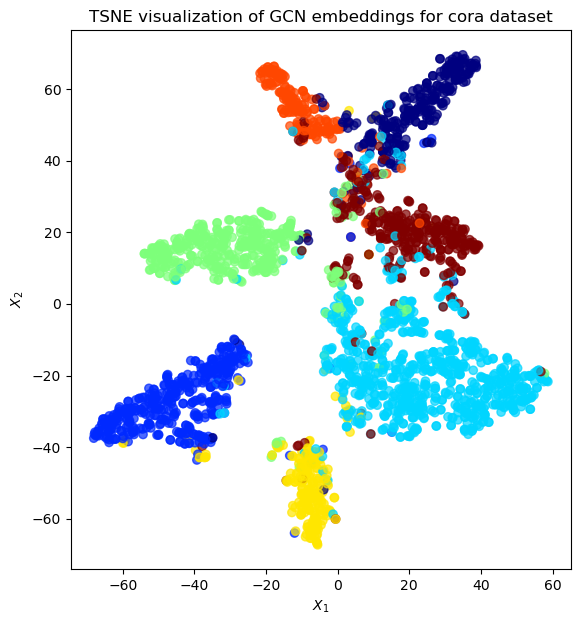

In [33]:
# embedding
embedding_model = Model( inputs = x_inp, outputs = x_out )
emb = embedding_model.predict( all_mapper )

from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

transform = TSNE # PCA

X = emb.squeeze(0)

trans = transform( n_components = 2 )
X_reduced = trans.fit_transform( X )

fig, ax = plt.subplots(figsize=(7, 7))
ax.scatter(
    X_reduced[:, 0],
    X_reduced[:, 1],
    c=node_subjects.astype("category").cat.codes,
    cmap="jet",
    alpha=0.7,
)
ax.set(
    aspect="equal",
    xlabel="$X_1$",
    ylabel="$X_2$",
    title=f"{transform.__name__} visualization of GCN embeddings for cora dataset",
)


## GAT model

In [18]:
from stellargraph.mapper import FullBatchNodeGenerator
from stellargraph.layer import GAT

In [19]:
# split data
train_subjects, test_subjects = model_selection.train_test_split(
    node_subjects, train_size=0.7, test_size=None, stratify=node_subjects, random_state=42
)

val_subjects, test_subjects = model_selection.train_test_split(
    test_subjects, train_size=0.5, test_size=None, stratify=test_subjects
)

In [20]:
from collections import Counter

Counter(train_subjects)

Counter({'Neural_Networks': 572,
         'Probabilistic_Methods': 298,
         'Rule_Learning': 126,
         'Case_Based': 209,
         'Genetic_Algorithms': 292,
         'Theory': 246,
         'Reinforcement_Learning': 152})

In [21]:
# Convert to numeric labels
le = preprocessing.LabelBinarizer()
train_targets = le.fit_transform(train_subjects)
val_targets = le.transform(val_subjects)
test_targets = le.transform(test_subjects)

In [22]:
# Create the GAT model
generator = FullBatchNodeGenerator(SG, method="gat")

In [23]:
train_gen = generator.flow(train_subjects.index, train_targets)

In [24]:
gat = GAT(
    layer_sizes=[32, 32],
    activations=["relu", "relu"],
    attn_heads=8,
    generator=generator,
    in_dropout=0.5,
    attn_dropout=0.5,
    normalize=None,
)

In [25]:
x_inp, x_out = gat.in_out_tensors()

In [26]:
predictions = layers.Dense(units=train_targets.shape[1], activation="softmax")(x_out)

In [27]:
model = Model(inputs=x_inp, outputs= predictions)
model.compile(
    optimizer=optimizers.Adam( learning_rate=0.005 ),
    loss=losses.categorical_crossentropy,
    metrics=["acc"],
)

In [28]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(1, 2708, 1433)]    0           []                               
                                                                                                  
 input_6 (InputLayer)           [(1, None, 2)]       0           []                               
                                                                                                  
 input_7 (InputLayer)           [(1, None)]          0           []                               
                                                                                                  
 dropout_6 (Dropout)            (1, 2708, 1433)      0           ['input_4[0][0]']                
                                                                                            

In [62]:
val_gen = generator.flow(val_subjects.index, val_targets)

In [63]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

if not os.path.isdir("logs"):
    os.makedirs("logs")
es_callback = EarlyStopping(
    monitor="val_acc", patience=20
)  # patience is the number of epochs to wait before early stopping in case of no further improvement
mc_callback = ModelCheckpoint(
    "logs/best_model.h5", monitor="val_acc", save_best_only=True, save_weights_only=True
)

In [64]:
history = model.fit(
    train_gen,
    epochs=200,
    validation_data=val_gen,
    verbose=2,
    shuffle=False,  # this should be False, since shuffling data means shuffling the whole graph
    callbacks=[es_callback, mc_callback],
)

Epoch 1/200
1/1 - 6s - loss: 1.9738 - acc: 0.1530 - val_loss: 1.8096 - val_acc: 0.3300 - 6s/epoch - 6s/step
Epoch 2/200
1/1 - 0s - loss: 1.8179 - acc: 0.3156 - val_loss: 1.6691 - val_acc: 0.3153 - 302ms/epoch - 302ms/step
Epoch 3/200
1/1 - 0s - loss: 1.6926 - acc: 0.3224 - val_loss: 1.5326 - val_acc: 0.3227 - 300ms/epoch - 300ms/step
Epoch 4/200
1/1 - 0s - loss: 1.5822 - acc: 0.3367 - val_loss: 1.3907 - val_acc: 0.3744 - 370ms/epoch - 370ms/step
Epoch 5/200
1/1 - 0s - loss: 1.4505 - acc: 0.3731 - val_loss: 1.2456 - val_acc: 0.5837 - 439ms/epoch - 439ms/step
Epoch 6/200
1/1 - 0s - loss: 1.3319 - acc: 0.4665 - val_loss: 1.1174 - val_acc: 0.7365 - 478ms/epoch - 478ms/step
Epoch 7/200
1/1 - 0s - loss: 1.2259 - acc: 0.5958 - val_loss: 1.0034 - val_acc: 0.7906 - 387ms/epoch - 387ms/step
Epoch 8/200
1/1 - 0s - loss: 1.0725 - acc: 0.6950 - val_loss: 0.8887 - val_acc: 0.8300 - 359ms/epoch - 359ms/step
Epoch 9/200
1/1 - 0s - loss: 0.9926 - acc: 0.7177 - val_loss: 0.7772 - val_acc: 0.8448 - 423ms

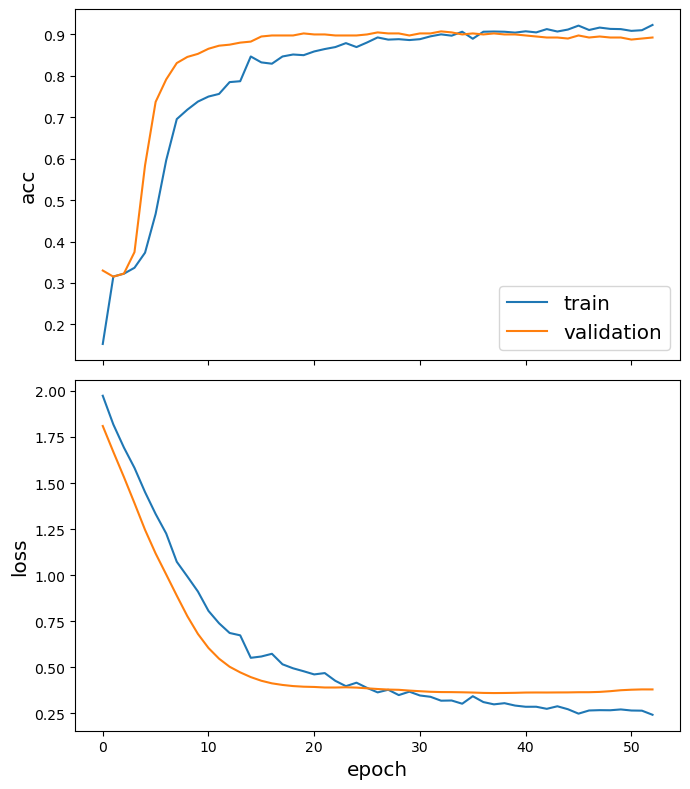

In [65]:
sg.utils.plot_history(history)

In [66]:
model.load_weights("logs/best_model.h5")

In [67]:
test_gen = generator.flow(test_subjects.index, test_targets)

In [68]:
test_metrics = model.evaluate(test_gen)
print("\nTest Set Metrics:")
for name, val in zip(model.metrics_names, test_metrics):
    print("\t{}: {:0.4f}".format(name, val))

1/1 [==============================] - 0s 123ms/step - loss: 0.3362 - acc: 0.8796

Test Set Metrics:
	loss: 0.3362
	acc: 0.8796


### Benchmark

In [69]:
# Prediction on the whole dataset
all_nodes = node_subjects.index
all_mapper = generator.flow(all_nodes)
all_predictions = model.predict(all_mapper)

1/1 [==============================] - 1s 568ms/step


In [70]:
# Inverse transform the predictions to get the node labels
node_predictions = le.inverse_transform(all_predictions.squeeze())

In [71]:
# Calculate benchmark metrics
df = pd.DataFrame({"Predicted": node_predictions, "True": node_subjects})
df.head(20)

y_pred = df['Predicted']
y_true = df['True']

precision, recall, f1, accuracy, cm, cr = calculate_metrics(y_true, y_pred)

print("F-1 score: ", f1)


F-1 score:  0.9194977843426884
